In [1]:
import numpy as np

from scipy.stats import norm
from tqdm import tqdm
import os

from Chempy.parameter import ModelParameters

import sbi.utils as utils

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle

import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
# ----- Load the data -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

elements = a.elements_to_trace

In [3]:
# ---  Load in the validation data ---
path_test = os.getcwd() + '/data/chempy_data/TNG_Test_Data.npz'
val_doutata = np.load(path_test, mmap_mode='r')

val_theta = val_data['params']
val_x = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y

val_theta, val_x     = clean_data(val_theta, val_x)

# convert to torch tensors
val_theta = torch.tensor(val_theta, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)

In [ ]:
# ----- Load posterior -----
with open('data/posterior_sbi_w5p-error_noH.pickle', 'rb') as f:
    posterior = pickle.load(f)

In [5]:
abundances =  torch.cat([val_x[:,:2], val_x[:,3:]], dim=1)

In [ ]:
theta_hat = torch.zeros_like(val_theta)
for index in tqdm(range(len(abundances))):
    thetas_predicted = posterior.sample((1000,), x=abundances[index], show_progress_bars=False)
    theta_predicted = thetas_predicted.mean(dim=0)
    theta_hat[index] = theta_predicted

In [3]:
ape = torch.abs((val_theta - theta_hat) / val_theta) *100

NameError: name 'val_theta' is not defined

In [4]:
ape = torch.load('data/ape_sbi_w5p-error_noH.pt')

In [ ]:
ape.shape

high_mass_slope : 1.9% + 1.8 - 1.0

log10_N_0 : 2.6% + 2.5 - 1.5

log10_starformation_efficiency : 71.0% + 90.1 - 31.5

log10_sfr_scale : 19.6% + 12.1 - 9.9

outflow_feedback_fraction : 24.4% + 17.7 - 12.6

time : 19.4% + 12.8 - 9.2



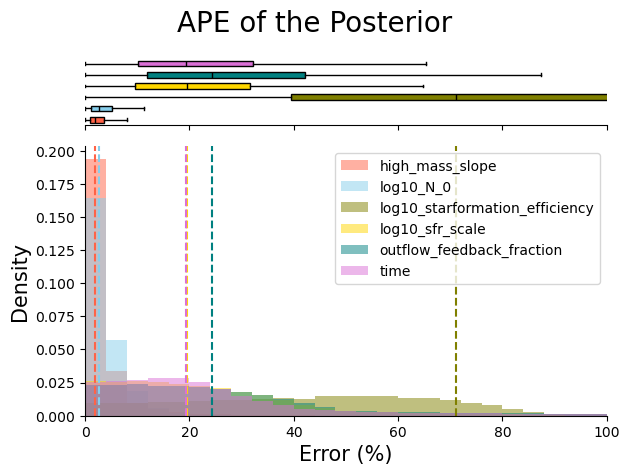

In [48]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
colors = ["tomato", "skyblue", "olive", "gold", "teal", "orchid"]

for i in range(6):
    l_quantile, median, u_quantile = np.percentile(ape[:,i], [25, 50, 75])
    ax_hist.hist(ape[:,i], bins=25, density=True, range=(0, 100), label=labels[i], color=colors[i], alpha=0.5)
    median = np.percentile(ape[:,i], 50)
    ax_hist.axvline(median, color=colors[i], linestyle='--')
    #print(labels[i] + fr' ${median:.1f}^{{+{u_quantile-median:.1f}}}_{{-{median-l_quantile:.1f}}}\%$')
    print(labels[i] + f" : {median:.1f}% + {u_quantile-median:.1f} - {median-l_quantile:.1f}")
    print()
    
ax_hist.set_xlabel('Error (%)', fontsize=15)
ax_hist.set_ylabel('Density', fontsize=15)
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.legend()

bplot = ax_box.boxplot(ape.T, vert=False, autorange=False, widths=0.5, patch_artist=True, showfliers=False, boxprops=dict(facecolor='tomato'), medianprops=dict(color='black'))
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
ax_box.set(yticks=[])
ax_box.spines['left'].set_visible(False)
ax_box.spines['right'].set_visible(False)
ax_box.spines['top'].set_visible(False)

fig.suptitle('APE of the Posterior', fontsize=20)
plt.xlim(0, 100)
fig.tight_layout()
plt.show()

In [64]:
torch.save(ape, 'data/ape_sbi_w5p-error_noH.pt')